In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1


In [2]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp

def loader(fname,fpath,backed=None) : 
    start = time.time()
    %memit adata = sc.read_h5ad(os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

if True :
    # load human
    fname='hum_MT_bbknn.h5ad'
    hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    hdata = loader(fname,pdfp)


peak memory: 20562.95 MiB, increment: 20358.30 MiB
loaded @200327.12:20:14
took 24.96-s to load data
peak memory: 159640.22 MiB, increment: 149215.96 MiB
loaded @200327.12:22:44
took 150.34-s to load data


In [103]:
def phateumap(X,plot=None,recalculate=False,save=None,title=None,bbknn=True,cluster='batch',cmap=None) :
    """Plot or recalculate then plot
    
    Args:
        X (AnnData): subsetted AnnData object
        plot (ax object): optional. give ax object to plot in multiple for loop 
        save (str): optional. Save the plot with the full filepath indicated, otherwise return ax
    """
    if recalculate :
        # umap/louvain based off batch-balanced graph
        sc.tl.pca(X,n_comps=100)
        if bbknn:
            sc.external.pp.bbknn(X,batch_key='batch')
        else :
            sc.pp.neighbors(X,n_neighbors=30,n_pcs=100)
        sc.tl.umap(X)
        sc.tl.louvain(X,resolution=0.5)

        # compute PHATE
        G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None

        phate_op = phate.PHATE(knn_dist='precomputed',
                               gamma=0,
                               n_jobs=-1)
        X.obsm['X_phate']=phate_op.fit_transform(G.K)
        
    if plot is not None :
        if not isinstance(plot,plt.Axes) :
            fig,ax=plt.subplots(1,2,figsize=(8,3))
        else :
            ax = plot
            
        if cluster=='louvain' :
            color = X.obs[cluster].astype(int)
        else :
            color = X.obs[cluster]
            
        if cmap is None :
            if cluster=='louvain':
                cmap = sns.color_palette('colorblind',len(X.obs[cluster].unique()))
                cmap = {v:cmap[i] for i,v in enumerate(np.unique(X.obs[cluster].astype(int)))}
            cmap = sns.color_palette('colorblind',len(X.obs['batch'].unique())) # problematic if n_batch > 12
            
        # pt_size 
#         s = 10*X.shape[0]*4.8602673147023086e-06 # based on s=0.2 for N=hdata.shape[0]

            
        scprep.plot.scatter2d(X.obsm['X_umap'],
                      c=color,
                      cmap=cmap,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax[0],
#                       s = s,
                      alpha=0.6,
                      title=title,
                      rasterized=True)
        scprep.plot.scatter2d(X.obsm['X_phate'],
                              c=color,
                              cmap=cmap,
                              ticks=None,
                              label_prefix='PHATE',
                              legend=True,
                              legend_loc=(1.01,0.1),
                              ax=ax[1],
#                               s = s,
                              alpha=0.6,
                              title=title,
                              rasterized=True)
        if save is not None :
            if '.pdf' in save :
                fig.savefig(save,dpi=300, bbox_inches='tight')
            else : 
                fig.savefig(save+'.pdf',dpi=300, bbox_inches='tight')
                
    return X 

        

In [77]:
# aesthetics
try :
    mdata.obs['genotype_timepoint']
except KeyError :
    mdata.obs['genotype_timepoint']=[v + ' WT' if 'WT' in mdata.obs['genotype'][i] else v + ' SCA1' for i,v in enumerate(mdata.obs['timepoint'])]
    mdata.obs['genotype_timepoint']=mdata.obs['genotype_timepoint'].astype('category')
cmap_mouse = {'5wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[1], 
              '5wk SCA1':sns.cubehelix_palette(8)[1], 
              '12wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[2], 
              '12wk SCA1':sns.cubehelix_palette(8)[2], 
              '18wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[3], 
              '18wk SCA1':sns.cubehelix_palette(8)[3], 
              '24wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[4], 
              '24wk SCA1':sns.cubehelix_palette(8)[4], 
              '30wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[5], 
              '30wk SCA1':sns.cubehelix_palette(8)[5]}

try :
    hdata.obs['genotype']
except KeyError :
    hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'CTRL' for i in hdata.obs['Sample']]
cmap_human = {'SCA1':sns.cubehelix_palette(8)[5],
              'CTRL':sns.cubehelix_palette(8,start=.5,rot=-.75)[5]}


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:46)
computing batch balanced neighbors
	finished (0:00:10)
computing UMAP
    finished (0:00:55)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:08)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 33356 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 14.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 28.89 seconds.
  Calculated landmark operator in 47.03 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.02 seconds.
  Calculating diffusion potential...
  Calculated diff

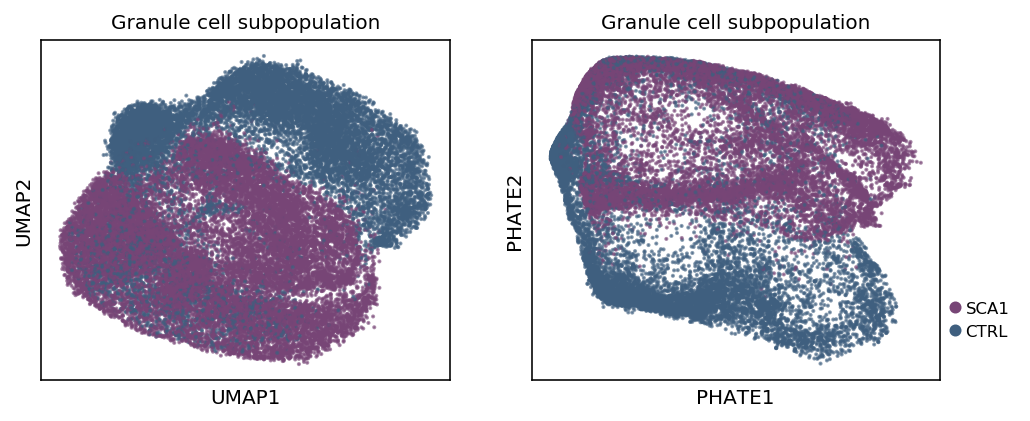

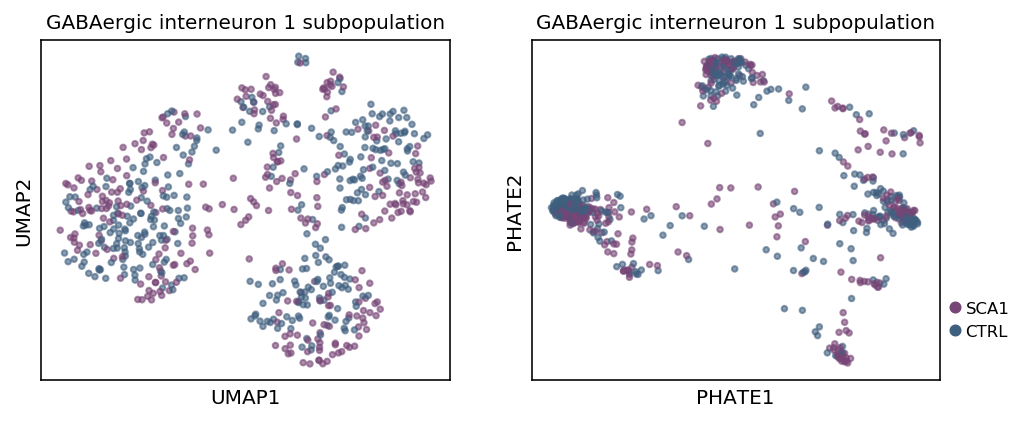

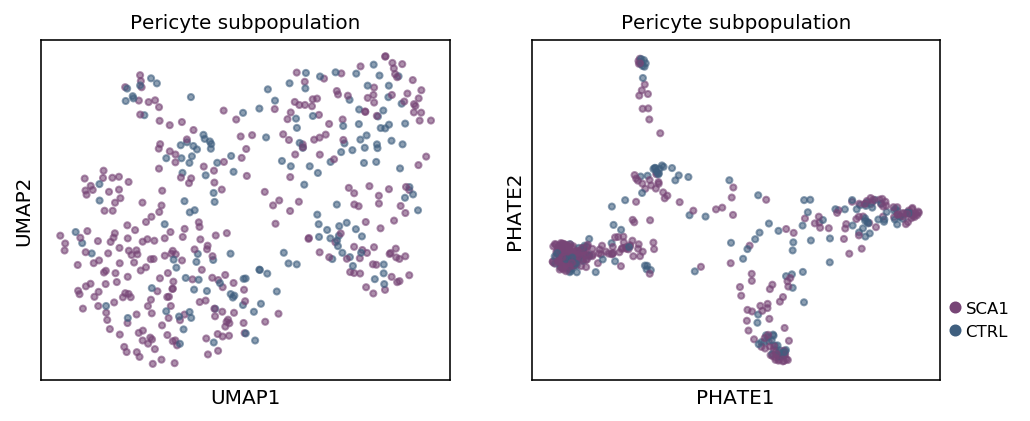

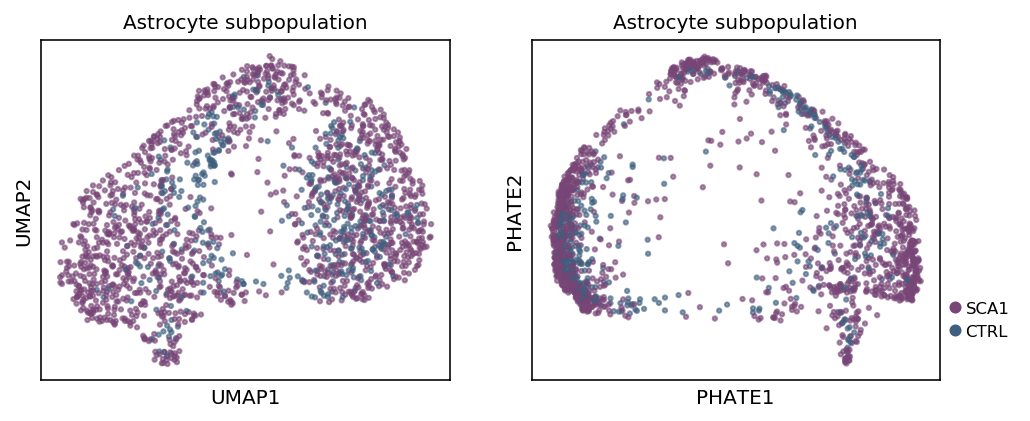

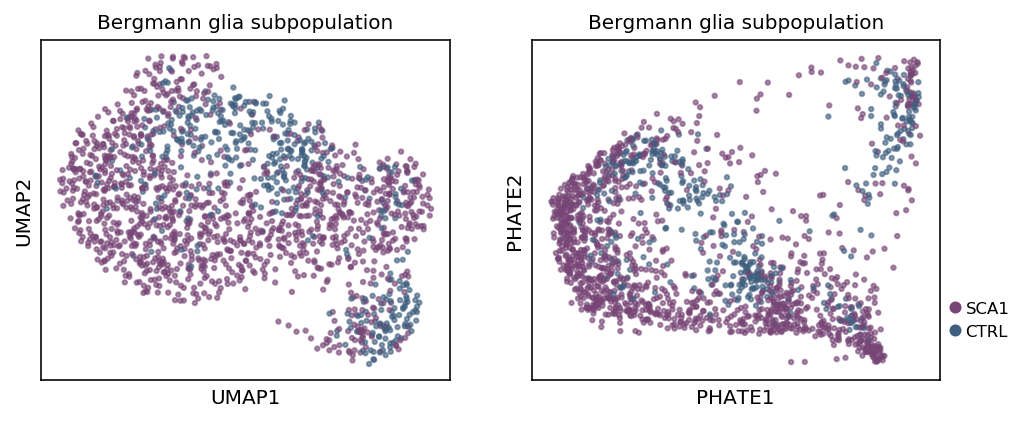

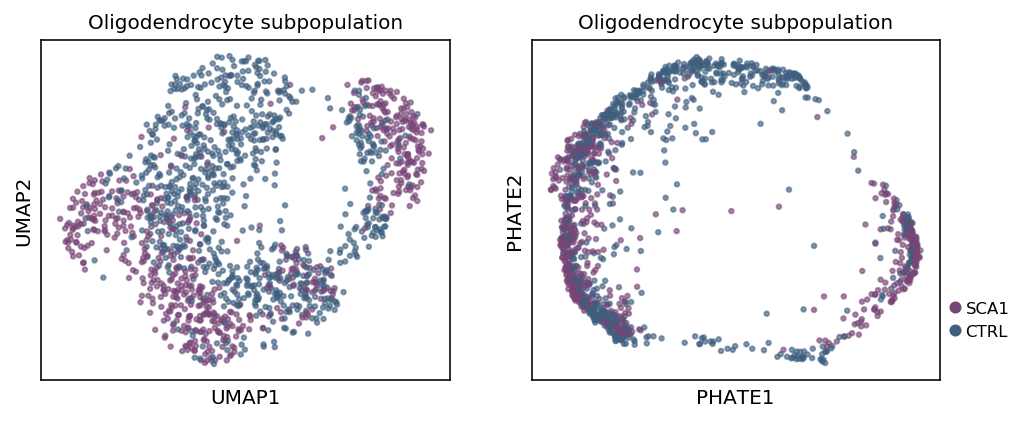

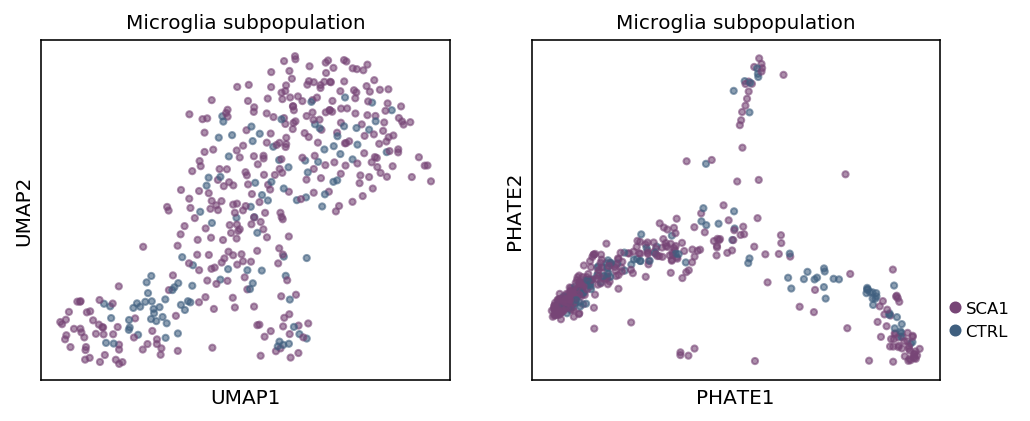

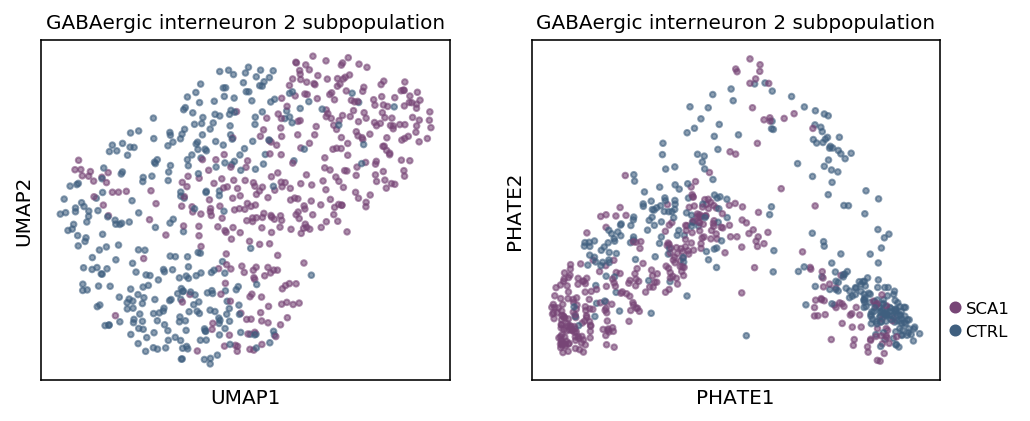

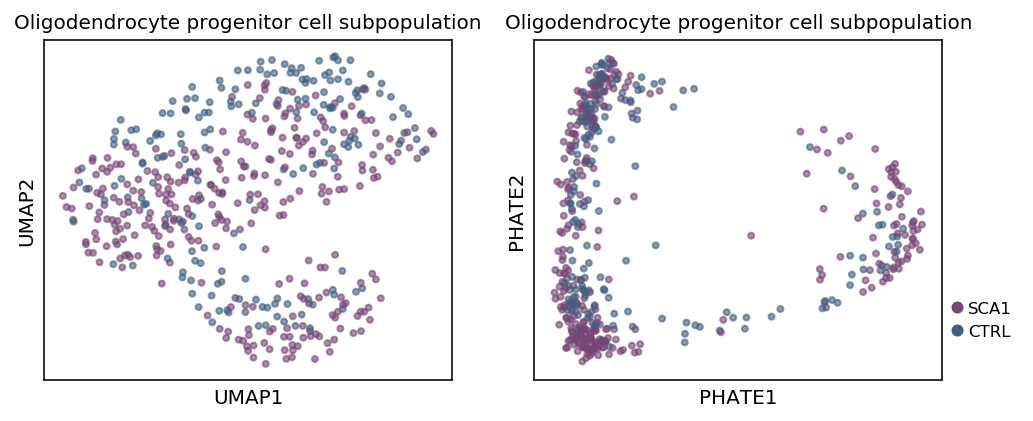

In [86]:
# human
# ctypes = ['Oligodendrocyte']
ctypes = hdata.obs['ctype'].unique()
total_embeds_ctype=time.time()
for i,ctype in enumerate(ctypes) :
    start = time.time()
    fname=os.path.join(pfp,'embeds_hum_'+ctype)
    X = hdata[(hdata.obs['ctype']==ctype),:]
    X = phateumap(X,plot=True,recalculate=True,save=fname,title=ctype+' subpopulation',
                  cluster='genotype',cmap=cmap_human)
    print('\n{} ({}/{}) subset done in {:.2f}-s\n'.format(ctype,i+1,len(ctypes),time.time() - start))
print('\n{} clusters in in {:.2f}-min'.format(len(ctypes),(time.time() - total_embeds_ctype)/60))

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:27)
computing batch balanced neighbors
	finished (0:00:11)
computing UMAP
    finished (0:01:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:06)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 9596 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.26 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 42.04 seconds.
  Calculated landmark operator in 55.26 seconds.
  Calculating optimal t...
  Calculated optimal t in 5.03 seconds.
  Calculating diffusion potential...
  Calculated diffus

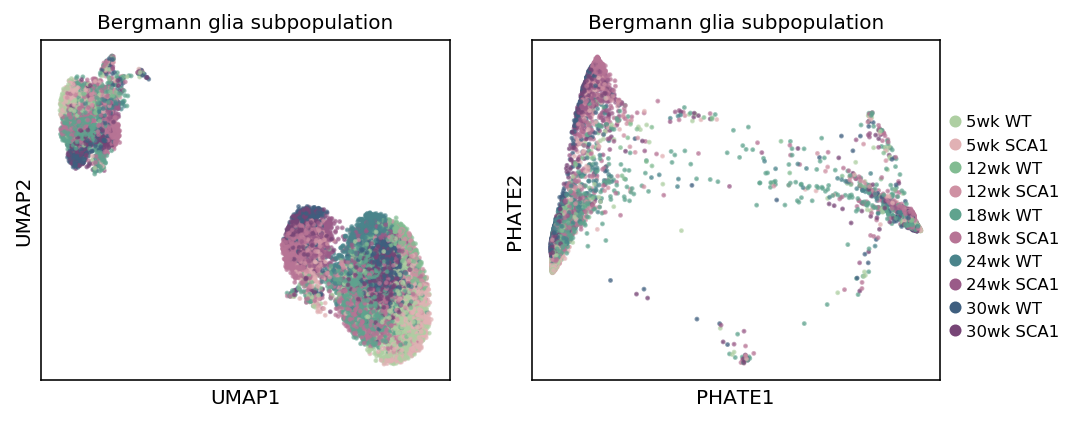

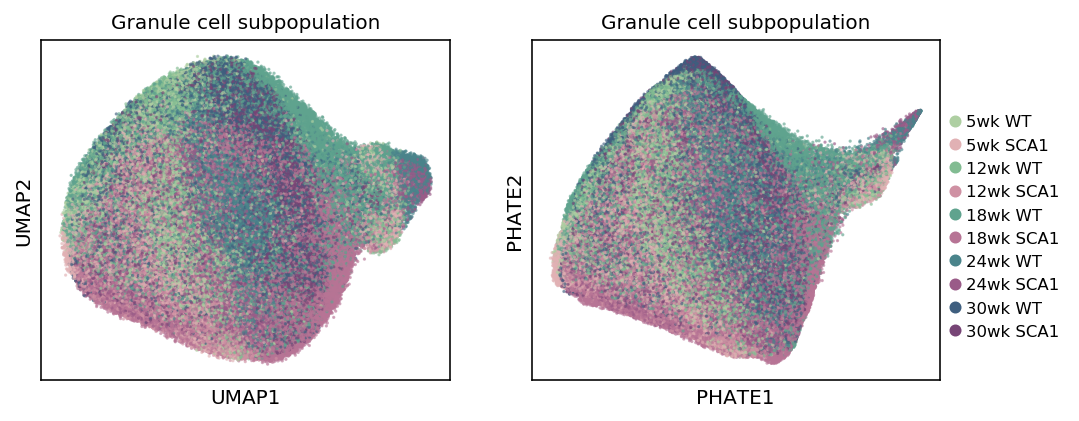

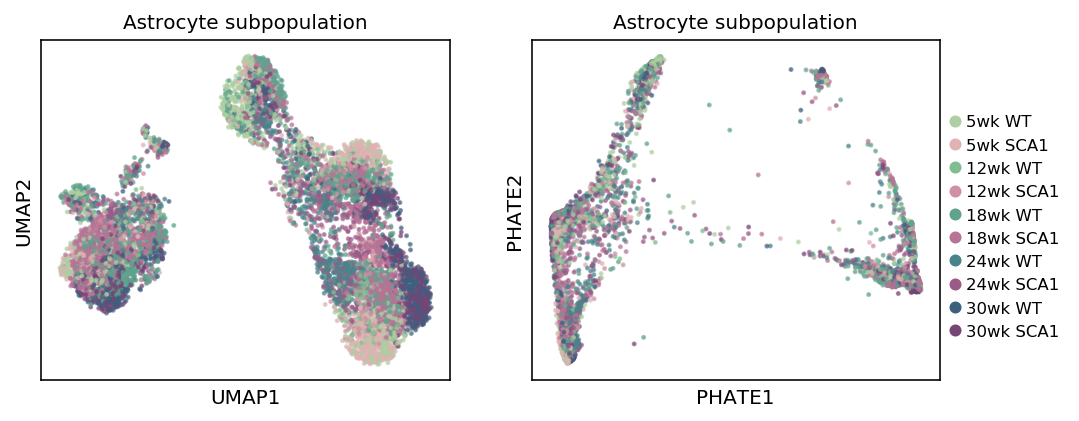

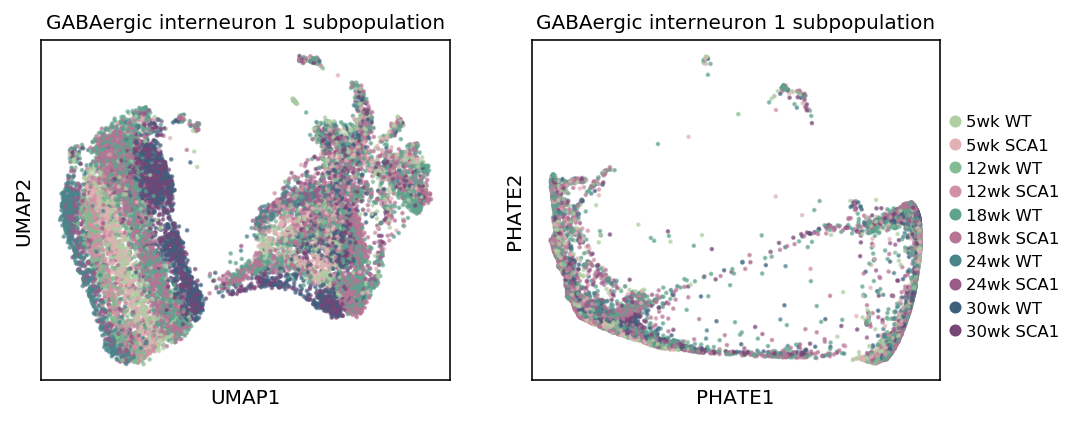

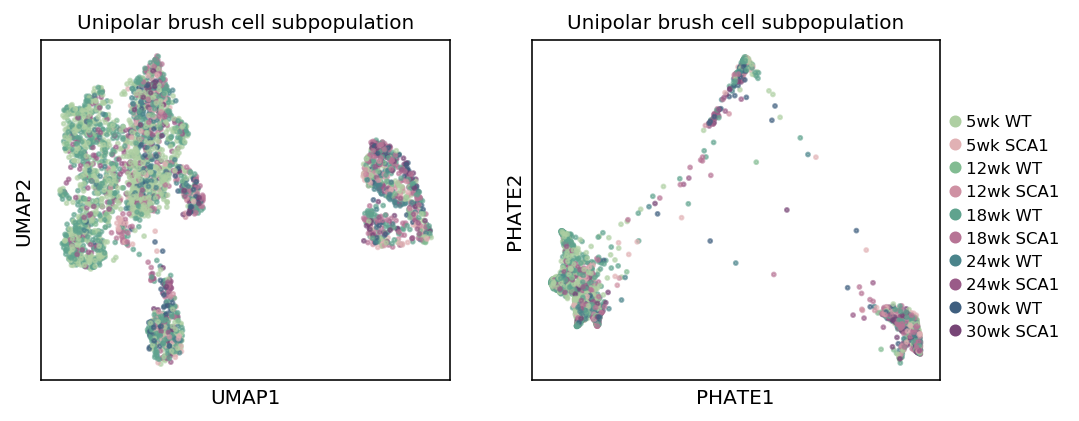

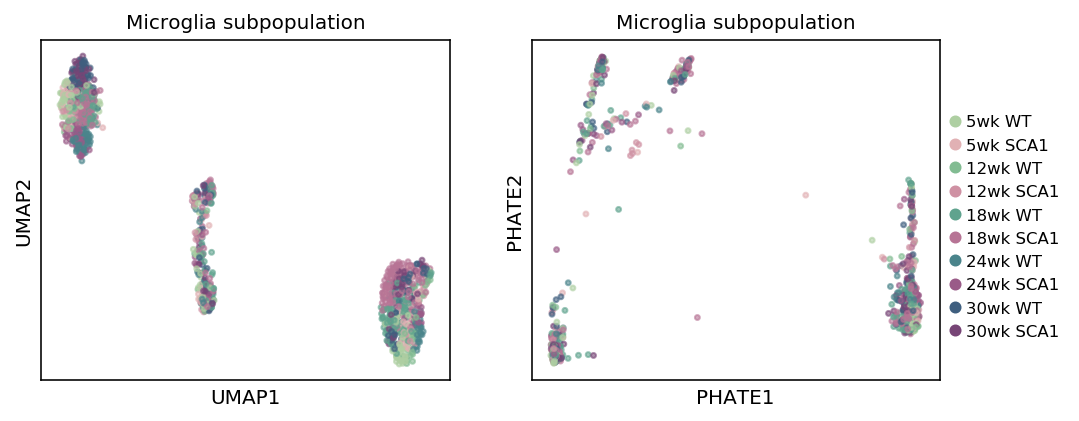

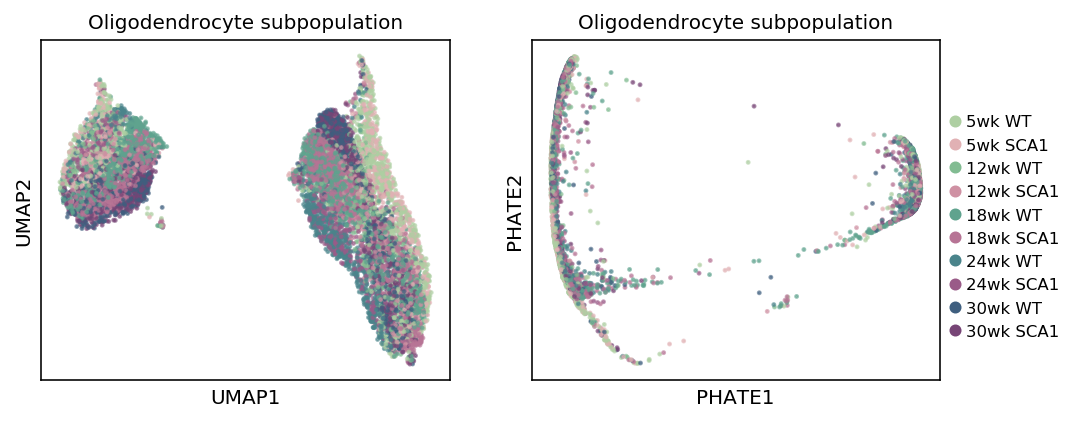

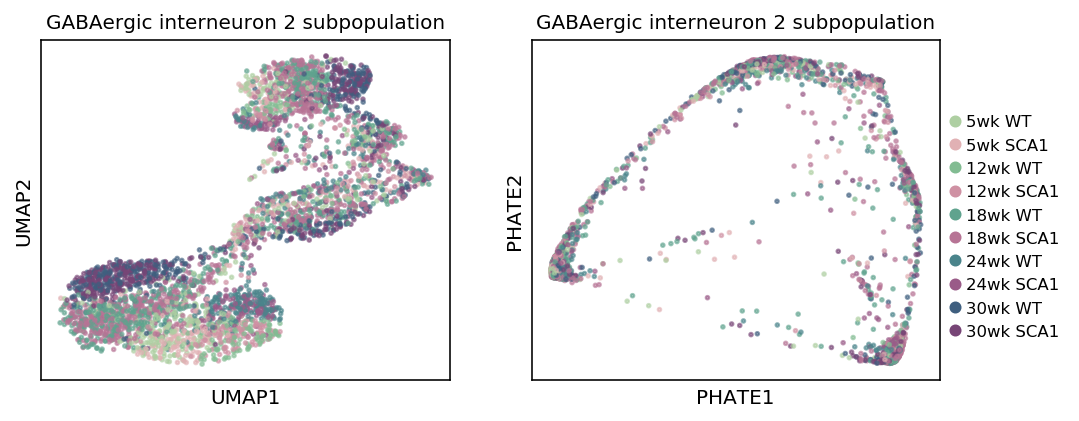

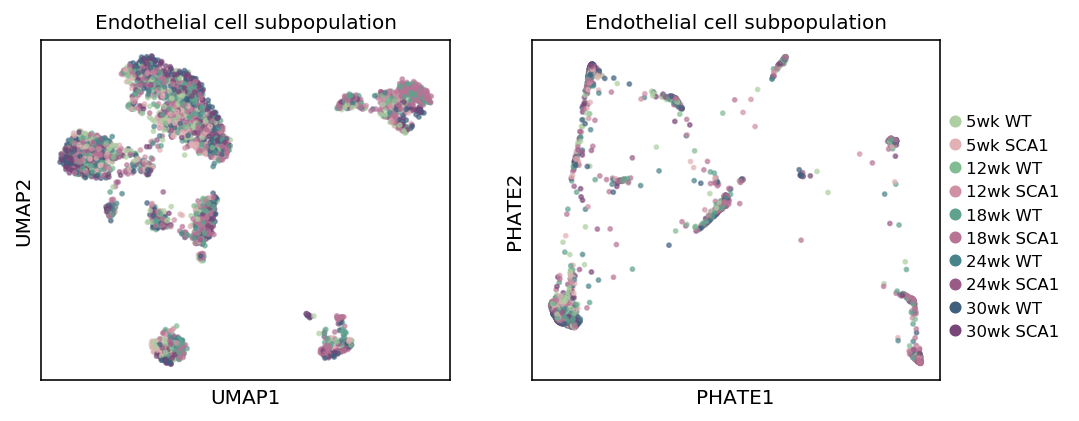

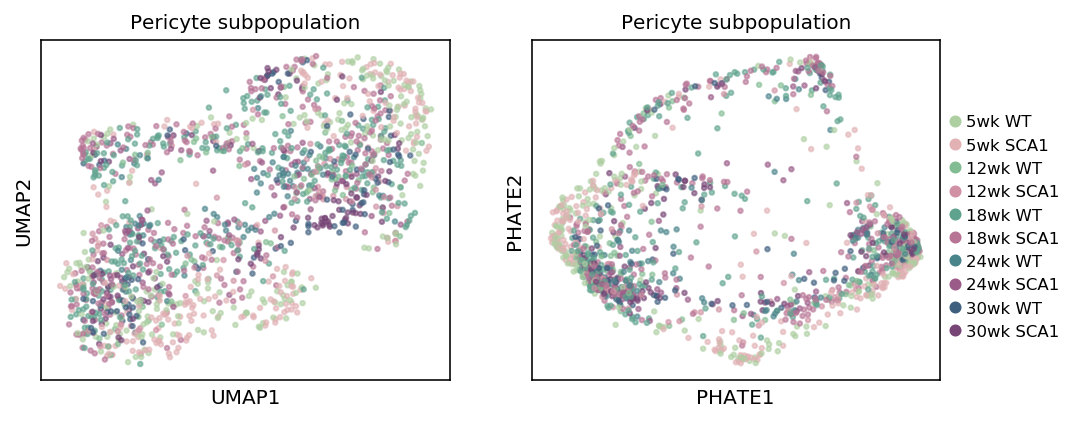

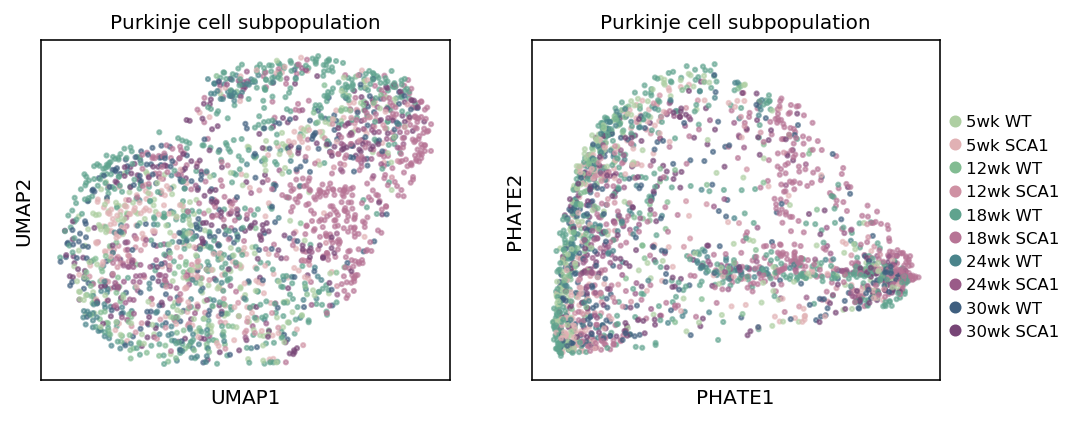

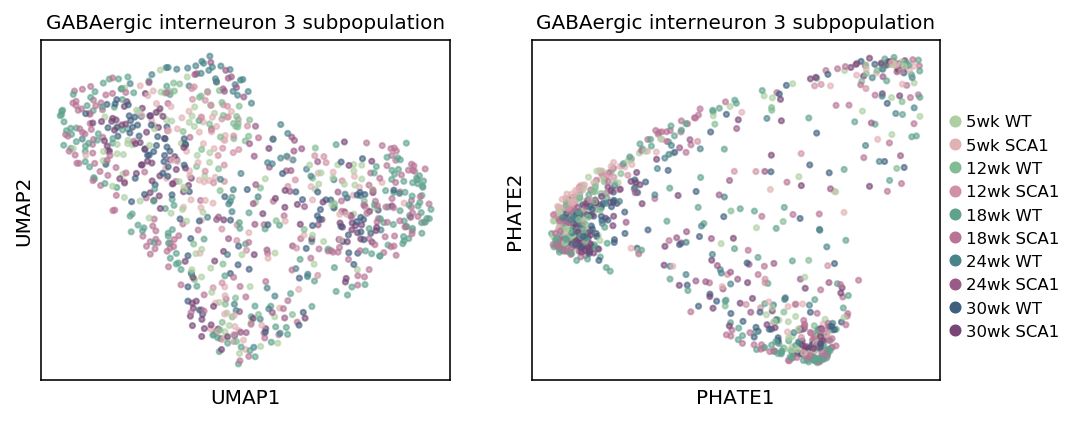

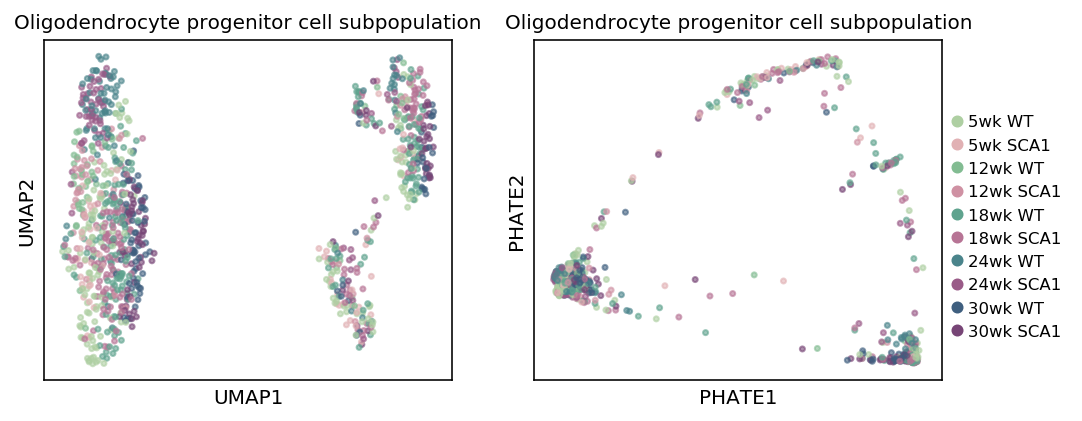

In [87]:
# mouse
ctypes = mdata.obs['ctype'].unique()
total_embeds_ctype=time.time()
for i,ctype in enumerate(ctypes) :
    start = time.time()
    fname=os.path.join(pfp,'embeds_mouse_'+ctype)
    X = mdata[(mdata.obs['ctype']==ctype),:]
    X = phateumap(X,plot=True,recalculate=True,save=fname,title=ctype+' subpopulation',
                  cluster='genotype_timepoint',cmap=cmap_mouse)
    print('\n{} ({}/{}) subset done in {:.2f}-s\n'.format(ctype,i+1,len(ctypes),time.time() - start))
print('\n{} clusters in in {:.2f}-min'.format(len(ctypes),(time.time() - total_embeds_ctype)/60))

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:03)
computing batch balanced neighbors
	finished (0:00:00)
computing UMAP
    finished (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 2014 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.28 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.26 seconds.
  Calculated landmark operator in 21.75 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.77 seconds.
  Calculating diffusion potential...
  Calculated diffus

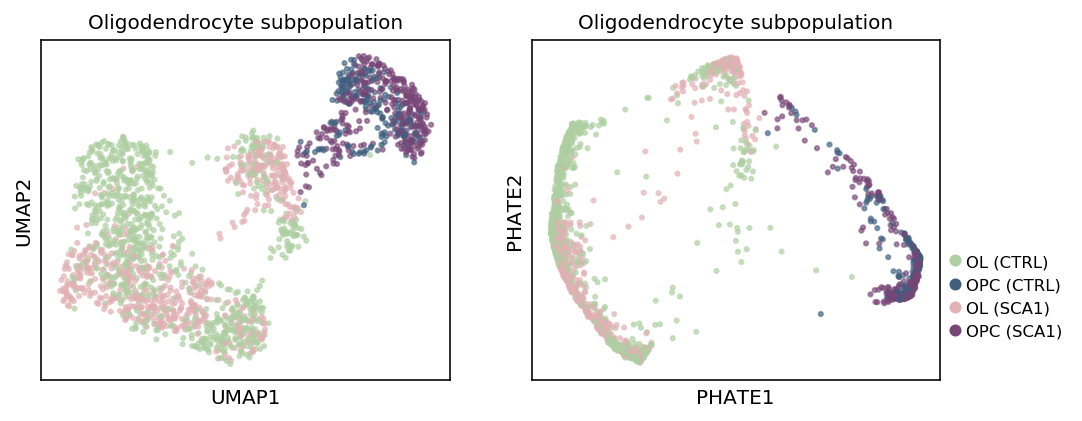

In [105]:
# OPC + OL
X = hdata[((hdata.obs['ctype']=='Oligodendrocyte')|
          (hdata.obs['ctype']=='Oligodendrocyte progenitor cell')),:]
X = phateumap(X,recalculate=True)

X.obs['ctype_genotype']=X.obs['genotype'].astype(str)
X.obs['ctype_genotype'][((X.obs['genotype']=='CTRL') & (X.obs['ctype']=='Oligodendrocyte'))]='OL (CTRL)'
X.obs['ctype_genotype'][((X.obs['genotype']=='CTRL') & (X.obs['ctype']=='Oligodendrocyte progenitor cell'))]='OPC (CTRL)'
X.obs['ctype_genotype'][((X.obs['genotype']=='SCA1') & (X.obs['ctype']=='Oligodendrocyte'))]='OL (SCA1)'
X.obs['ctype_genotype'][((X.obs['genotype']=='SCA1') & (X.obs['ctype']=='Oligodendrocyte progenitor cell'))]='OPC (SCA1)'

cmap = {'OL (CTRL)':sns.cubehelix_palette(8,start=.5,rot=-.75)[1], 
        'OPC (CTRL)':sns.cubehelix_palette(8,start=.5,rot=-.75)[5], 
        'OL (SCA1)':sns.cubehelix_palette(8)[1], 
        'OPC (SCA1)':sns.cubehelix_palette(8)[5]}


fig,ax=plt.subplots(1,2,figsize=(8,3))
title='Oligodendrocyte subpopulation'
cluster='ctype_genotype'

scprep.plot.scatter2d(X.obsm['X_umap'],
              c=X.obs[cluster],
              cmap=cmap,
              ticks=None,
              label_prefix='UMAP',
              legend=False,
              ax=ax[0],
#                       s = s,
              alpha=0.6,
              title=title,
              rasterized=True)
scprep.plot.scatter2d(X.obsm['X_phate'],
                      c=X.obs[cluster],
                      cmap=cmap,
                      ticks=None,
                      label_prefix='PHATE',
                      legend=True,
                      legend_loc=(1.01,0.1),
                      ax=ax[1],
#                               s = s,
                      alpha=0.6,
                      title=title,
                      rasterized=True)
if True :
    fig.savefig(os.path.join(pfp,'embeds_hum_OPC+OL.pdf'),dpi=300, bbox_inches='tight')

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:02:06)
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished (0:01:59)
computing UMAP
    finished (0:04:40)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:01:07)
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 90495 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 1.46 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 29.71 seconds.
    Calculating KMeans...
    Calculated KMeans in 54.40 seconds.
  Calculated landmark operator in 90.53 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.17 seconds.
  Calculating diffusion potenti

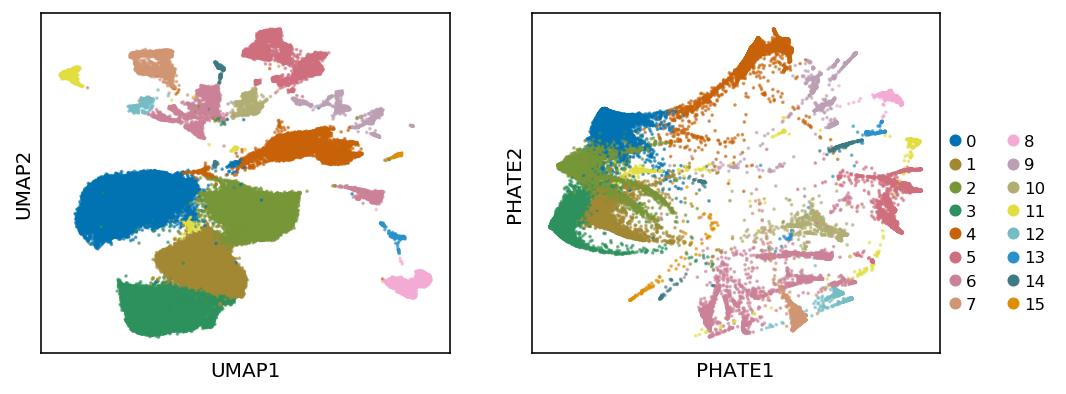

In [106]:
# for Aagam
X = mdata[((mdata.obs['timepoint']=='12wk') |
         (mdata.obs['timepoint']=='24wk')),:]
X = phateumap(X,plot=True,recalculate=True,save=None,title=None,bbknn=False,cluster='louvain',cmap=None)

In [95]:
len(X.obs.louvain.unique())

32